# Sravan Sreereddy_ Gesture_Recognition

## Gesture Recognition by Sravan & Ashish
In this group project, you are going to build a 3D Conv model that will be able to predict the 5 gestures correctly. Please import the following libraries to get started.

In [1]:
import numpy as np
import os
from skimage.transform import resize
from skimage.io import imread
import datetime

We set the random seed so that the results don't vary drastically.

In [2]:
np.random.seed(30)
import random as rn
rn.seed(30)
from keras import backend as K
import tensorflow as tf
tf.set_random_seed(30)

Using TensorFlow backend.


In this block, you read the folder names for training and validation. You also set the `batch_size` here. Note that you set the batch size in such a way that you are able to use the GPU in full capacity. You keep increasing the batch size until the machine throws an error.

In [3]:
train_doc = np.random.permutation(open('./Project_data/train.csv').readlines())
val_doc = np.random.permutation(open('./Project_data/val.csv').readlines())
#batch_size = 64
batch_size = 32

## Generator
This is one of the most important part of the code. The overall structure of the generator has been given. In the generator, you are going to preprocess the images as you have images of 2 different dimensions as well as create a batch of video frames. You have to experiment with `img_idx`, `y`,`z` and normalization such that you get high accuracy.

In [4]:
def prepare_batch(shuffled_folders, batch_size, batch_idx, img_idx, source_path):
    batch_data = np.zeros((batch_size,len(img_idx),100,100,3)) 
    batch_labels = np.zeros((batch_size,5)) # batch_labels is the one hot representation of the output
    for folder in range(batch_size): # iterate over the batch_size
        imgs = os.listdir(source_path+'/'+ shuffled_folders[folder + (batch_idx*batch_size)].split(';')[0]) # read all the images in the folder
        for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
            image = imread(source_path+'/'+ shuffled_folders[folder + (batch_idx*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)

            #cropping image if size is unequal
            if image.shape[0] != image.shape[1]:
                image = image[:,20:140]
            #resizing image
            image_resized = resize(image, (100,100))
            #normalizing each channel
            batch_data[folder,idx,:,:,0] = image_resized[:,:,0]/255
            batch_data[folder,idx,:,:,1] = image_resized[:,:,1]/255
            batch_data[folder,idx,:,:,2] = image_resized[:,:,2]/255

        batch_labels[folder, int(shuffled_folders[folder + (batch_idx*batch_size)].strip().split(';')[2])] = 1
    return (batch_data, batch_labels)

In [22]:
def generator(source_path, folder_list, batch_size, ablation=None):
    print( 'Source path = ', source_path, '; batch size =', batch_size)
#     img_idx = list(range(0,30))
    img_idx = list(range(0,30,2))
    shuffled_folders = np.random.permutation(folder_list)
    if ablation is not None:
        while True:
            num_batches = int(np.floor(ablation/batch_size))
            for batch in range(num_batches):
                batch_data, batch_labels = prepare_batch(shuffled_folders, batch_size, 0, img_idx, source_path)
                yield batch_data, batch_labels
    else:
        while True:
            num_batches = int(np.floor(len(folder_list)/batch_size))
            for batch_idx in range(num_batches):
                batch_data, batch_labels = prepare_batch(shuffled_folders, batch_size, batch_idx, img_idx, source_path)
                yield batch_data, batch_labels
            remaining_data = len(folder_list)%batch_size
            if remaining_data > 0:
                batch_data, batch_labels = prepare_batch(shuffled_folders, remaining_data, num_batches, img_idx, source_path)
                yield batch_data, batch_labels

Note here that a video is represented above in the generator as (number of images, height, width, number of channels). Take this into consideration while creating the model architecture.

In [23]:
curr_dt_time = datetime.datetime.now()
train_path = './Project_data/train'
val_path = './Project_data/val'
num_train_sequences = len(train_doc)
print('# training sequences =', num_train_sequences)
num_val_sequences = len(val_doc)
print('# validation sequences =', num_val_sequences)

# training sequences = 663
# validation sequences = 100


## Model
Here you make the model using different functionalities that Keras provides. Remember to use `Conv3D` and `MaxPooling3D` and not `Conv2D` and `Maxpooling2D` for a 3D convolution model. You would want to use `TimeDistributed` while building a Conv2D + RNN model. Also remember that the last layer is the softmax. Design the network in such a way that the model is able to give good accuracy on the least number of parameters so that it can fit in the memory of the webcam.

In [7]:
from keras.models import Sequential, Model
from keras.layers import Dense, GRU, Flatten, TimeDistributed, Flatten, BatchNormalization, Activation, Dropout
from keras.layers.recurrent import LSTM
from keras.layers.convolutional import Conv2D, Conv3D, MaxPooling2D, MaxPooling3D
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras.applications.vgg16 import VGG16
from keras.applications.mobilenet import MobileNet
from keras import optimizers

In [8]:
import matplotlib.pyplot as plt

In [9]:
def plot(history):
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,4))
    axes[0].plot(history.history['loss'])   
    axes[0].plot(history.history['val_loss'])
    axes[0].legend(['loss','val_loss'])

    axes[1].plot(history.history['categorical_accuracy'])   
    axes[1].plot(history.history['val_categorical_accuracy'])
    axes[1].legend(['categorical_accuracy','val_categorical_accuracy'])

In [10]:
def get_callback_list():
    curr_dt_time = datetime.datetime.now()
    model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'

    if not os.path.exists(model_name):
        os.mkdir(model_name)

    filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

    checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)

    LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.001)
    callbacks_list = [checkpoint, LR]
    return callbacks_list

In [24]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

## Conv2D + LSTM

In [ ]:
#Model 0 simple 2 layers 

In [ ]:
# Attempted training 120x120 resolution image with 64 batch_size
# kernel unresponsive with OOMError
# Had to restart

# Continuing by using 100x100 resolution
# batch_size=32

In [12]:
model0 = Sequential()
model0.add(TimeDistributed(Conv2D(32, (3, 3), padding='same', activation='relu'), input_shape=(30, 100, 100, 3)))
model0.add(TimeDistributed(BatchNormalization()))

model0.add(TimeDistributed(MaxPooling2D(pool_size=(2, 2))))

model0.add(TimeDistributed(Conv2D(64, (3, 3), padding='same', activation='relu')))
model0.add(TimeDistributed(BatchNormalization()))

model0.add(TimeDistributed(MaxPooling2D(pool_size=(2, 2))))

model0.add(TimeDistributed(Flatten()))

model0.add(LSTM(64))

model0.add(Dense(64, activation='relu'))

model0.add(Dense(5, activation='softmax'))

In [13]:
optimiser = optimizers.SGD(lr=0.01)
model0.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model0.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_1 (TimeDist (None, 30, 100, 100, 32)  896       
_________________________________________________________________
time_distributed_2 (TimeDist (None, 30, 100, 100, 32)  128       
_________________________________________________________________
time_distributed_3 (TimeDist (None, 30, 50, 50, 32)    0         
_________________________________________________________________
time_distributed_4 (TimeDist (None, 30, 50, 50, 64)    18496     
_________________________________________________________________
time_distributed_5 (TimeDist (None, 30, 50, 50, 64)    256       
_________________________________________________________________
time_distributed_6 (TimeDist (None, 30, 25, 25, 64)    0         
_________________________________________________________________
time_distributed_7 (TimeDist (None, 30, 40000)         0         
__________

Let us create the `train_generator` and the `val_generator` which will be used in `.fit_generator`.

In [14]:
callbacks_list = get_callback_list()

In [ ]:
#Ablation experiment with 100 sequences in train and 50 in validation dataset

In [15]:
train_generator_ab = generator(train_path, train_doc, batch_size, ablation=100)
val_generator_ab = generator(val_path, val_doc, batch_size, ablation=50)

In [16]:
history_ab_30=model0.fit_generator(train_generator_ab, steps_per_epoch=steps_per_epoch, epochs=5, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator_ab, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  ./Project_data/val ; batch size = 32
Source path =  ./Project_data/train ; batch size = 32
Epoch 1/5


/mnt/disks/user/anaconda3/lib/python3.6/site-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/mnt/disks/user/anaconda3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


21/21 [==============================] - 202s 10s/step - loss: 0.5421 - categorical_accuracy: 0.9271 - val_loss: 1.3928 - val_categorical_accuracy: 0.4062

Epoch 00001: saving model to model_init_2020-08-1617_26_25.558262/model-00001-0.54212-0.92708-1.39278-0.40625.h5
Epoch 2/5
21/21 [==============================] - 124s 6s/step - loss: 0.1491 - categorical_accuracy: 1.0000 - val_loss: 1.4679 - val_categorical_accuracy: 0.3750

Epoch 00002: saving model to model_init_2020-08-1617_26_25.558262/model-00002-0.14913-1.00000-1.46790-0.37500.h5
Epoch 3/5
21/21 [==============================] - 112s 5s/step - loss: 0.0946 - categorical_accuracy: 1.0000 - val_loss: 1.4839 - val_categorical_accuracy: 0.3750

Epoch 00003: saving model to model_init_2020-08-1617_26_25.558262/model-00003-0.09461-1.00000-1.48388-0.37500.h5
Epoch 4/5
21/21 [==============================] - 107s 5s/step - loss: 0.0728 - categorical_accuracy: 1.0000 - val_loss: 1.4919 - val_categorical_accuracy: 0.4062

Epoch 0000

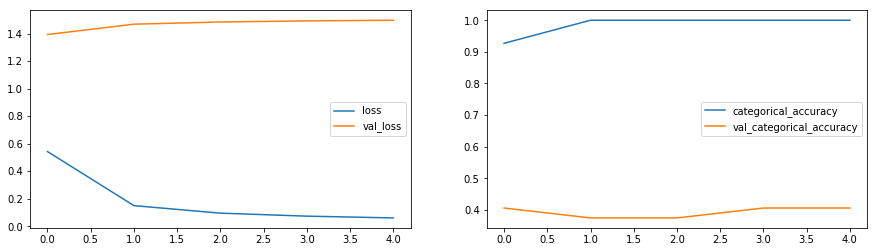

In [18]:
plot(history_ab_30)

In [ ]:
# Trying to train the same model with 15 images (picked alternate images)

In [25]:
history_ab=model0.fit_generator(train_generator_ab, steps_per_epoch=steps_per_epoch, epochs=5, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator_ab, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  ./Project_data/val ; batch size = 32
Source path =  ./Project_data/train ; batch size = 32
Epoch 1/5


/mnt/disks/user/anaconda3/lib/python3.6/site-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/mnt/disks/user/anaconda3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


21/21 [==============================] - 72s 3s/step - loss: 0.5102 - categorical_accuracy: 0.9390 - val_loss: 1.7275 - val_categorical_accuracy: 0.2500

Epoch 00001: saving model to model_init_2020-08-1608_53_03.430813/model-00001-0.51020-0.93899-1.72749-0.25000.h5
Epoch 2/5
21/21 [==============================] - 60s 3s/step - loss: 0.1395 - categorical_accuracy: 1.0000 - val_loss: 1.7524 - val_categorical_accuracy: 0.2812

Epoch 00002: saving model to model_init_2020-08-1608_53_03.430813/model-00002-0.13948-1.00000-1.75237-0.28125.h5
Epoch 3/5
21/21 [==============================] - 56s 3s/step - loss: 0.0945 - categorical_accuracy: 1.0000 - val_loss: 1.7660 - val_categorical_accuracy: 0.2812

Epoch 00003: saving model to model_init_2020-08-1608_53_03.430813/model-00003-0.09447-1.00000-1.76602-0.28125.h5
Epoch 4/5
21/21 [==============================] - 60s 3s/step - loss: 0.0738 - categorical_accuracy: 1.0000 - val_loss: 1.7502 - val_categorical_accuracy: 0.2812

Epoch 00004: sa

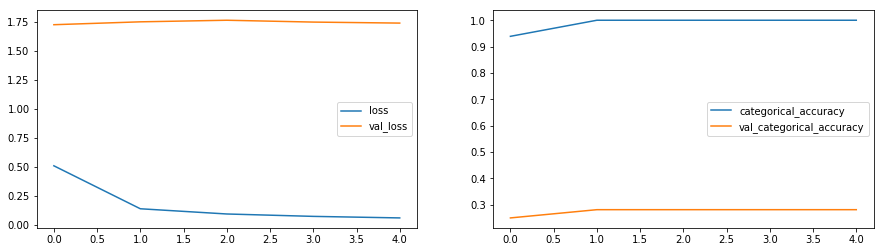

In [26]:
plot(history_ab)

In [ ]:
#Model takes half the time to train if 15 images are considered from the sequence for training
#But learning seems to have taken place in both the cases

#Hence continuing with experiments with 15 images here on

In [ ]:
#Overall, model overfits in ablation, hence can assume that the model is able to learn

In [ ]:
#Training on full dataset

In [27]:
train_generator0 = generator(train_path, train_doc, batch_size)
val_generator0 = generator(val_path, val_doc, batch_size)

In [11]:
def get_callback_list():
    curr_dt_time = datetime.datetime.now()
    model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'

    if not os.path.exists(model_name):
        os.mkdir(model_name)

    filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

    checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)

    LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.001)
    callbacks_list = [checkpoint, LR]
    return callbacks_list

In [29]:
callbacks_list = get_callback_list()

In [30]:
history=model0.fit_generator(train_generator0, steps_per_epoch=steps_per_epoch, epochs=10, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator0, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  ./Project_data/val ; batch size = 32
Source path =  ./Project_data/train ; batch size =Epoch 1/10
 32


/mnt/disks/user/anaconda3/lib/python3.6/site-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/mnt/disks/user/anaconda3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


21/21 [==============================] - 135s 6s/step - loss: 1.4812 - categorical_accuracy: 0.3811 - val_loss: 1.4338 - val_categorical_accuracy: 0.4100

Epoch 00001: saving model to model_init_2020-08-1608_53_03.430813/model-00001-1.48530-0.37707-1.43375-0.41000.h5
Epoch 2/10
21/21 [==============================] - 54s 3s/step - loss: 1.1523 - categorical_accuracy: 0.6196 - val_loss: 1.3554 - val_categorical_accuracy: 0.4900

Epoch 00002: saving model to model_init_2020-08-1608_53_03.430813/model-00002-1.15786-0.61689-1.35542-0.49000.h5
Epoch 3/10
21/21 [==============================] - 53s 3s/step - loss: 0.8759 - categorical_accuracy: 0.7642 - val_loss: 1.1815 - val_categorical_accuracy: 0.5600

Epoch 00003: saving model to model_init_2020-08-1608_53_03.430813/model-00003-0.88111-0.76169-1.18147-0.56000.h5
Epoch 4/10
21/21 [==============================] - 58s 3s/step - loss: 0.6530 - categorical_accuracy: 0.8571 - val_loss: 1.1039 - val_categorical_accuracy: 0.5800

Epoch 00004

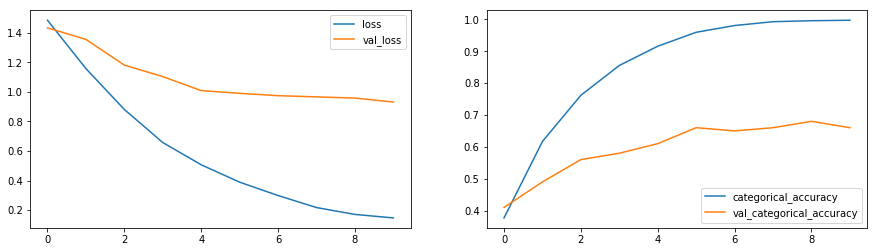

In [31]:
plot(history)

In [ ]:
#seems to overfit, hence adding dropouts

In [ ]:
#Trying with dropouts

In [37]:
model0_dr = Sequential()
model0_dr.add(TimeDistributed(Conv2D(32, (3, 3), padding='same', activation='relu'), input_shape=(15, 100, 100, 3)))
model0_dr.add(TimeDistributed(BatchNormalization()))

model0_dr.add(TimeDistributed(MaxPooling2D(pool_size=(2, 2))))

model0_dr.add(TimeDistributed(Conv2D(64, (3, 3), padding='same', activation='relu')))
model0_dr.add(TimeDistributed(BatchNormalization()))

model0_dr.add(TimeDistributed(MaxPooling2D(pool_size=(2, 2))))

model0_dr.add(TimeDistributed(Flatten()))

model0_dr.add(LSTM(64))
model0_dr.add(Dropout(0.25))

model0_dr.add(Dense(64, activation='relu'))
model0_dr.add(Dropout(0.25))

model0_dr.add(Dense(5, activation='softmax'))

In [38]:
train_generator0_dr = generator(train_path, train_doc, batch_size)
val_generator0_dr = generator(val_path, val_doc, batch_size)

callbacks_list = get_callback_list()

In [39]:
optimiser = optimizers.SGD(lr=0.01)
model0_dr.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model0_dr.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_36 (TimeDis (None, 15, 100, 100, 32)  896       
_________________________________________________________________
time_distributed_37 (TimeDis (None, 15, 100, 100, 32)  128       
_________________________________________________________________
time_distributed_38 (TimeDis (None, 15, 50, 50, 32)    0         
_________________________________________________________________
time_distributed_39 (TimeDis (None, 15, 50, 50, 64)    18496     
_________________________________________________________________
time_distributed_40 (TimeDis (None, 15, 50, 50, 64)    256       
_________________________________________________________________
time_distributed_41 (TimeDis (None, 15, 25, 25, 64)    0         
_________________________________________________________________
time_distributed_42 (TimeDis (None, 15, 40000)         0         
__________

In [41]:
history0_dr=model0_dr.fit_generator(train_generator0_dr, steps_per_epoch=steps_per_epoch, epochs=10, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator0_dr, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  ./Project_data/val ; batch size = 32
Source path =  ./Project_data/train Epoch 1/10; batch size = 32



/mnt/disks/user/anaconda3/lib/python3.6/site-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/mnt/disks/user/anaconda3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


21/21 [==============================] - 67s 3s/step - loss: 1.5422 - categorical_accuracy: 0.3157 - val_loss: 1.5072 - val_categorical_accuracy: 0.3200

Epoch 00001: saving model to model_init_2020-08-1608_53_03.430813/model-00001-1.54458-0.31523-1.50719-0.32000.h5
Epoch 2/10
21/21 [==============================] - 52s 2s/step - loss: 1.3630 - categorical_accuracy: 0.4301 - val_loss: 1.4135 - val_categorical_accuracy: 0.3900

Epoch 00002: saving model to model_init_2020-08-1608_53_03.430813/model-00002-1.36631-0.42836-1.41347-0.39000.h5
Epoch 3/10
21/21 [==============================] - 58s 3s/step - loss: 1.1910 - categorical_accuracy: 0.5671 - val_loss: 1.3244 - val_categorical_accuracy: 0.4300

Epoch 00003: saving model to model_init_2020-08-1608_53_03.430813/model-00003-1.19206-0.56712-1.32439-0.43000.h5
Epoch 4/10
21/21 [==============================] - 54s 3s/step - loss: 1.0549 - categorical_accuracy: 0.6369 - val_loss: 1.3016 - val_categorical_accuracy: 0.4300

Epoch 00004:

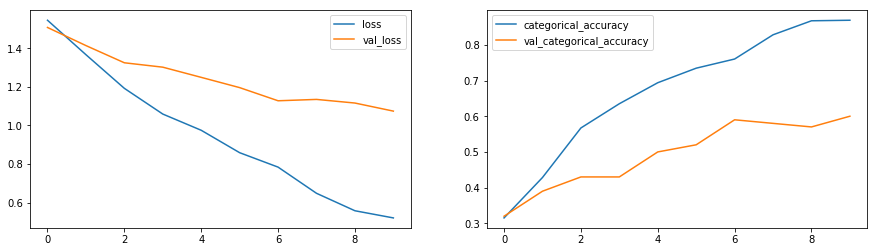

In [42]:
plot(history0_dr)

In [ ]:
#adding momentum=0.9 in optimizer

In [48]:
model0_mom = Sequential()
model0_mom.add(TimeDistributed(Conv2D(32, (3, 3), padding='same', activation='relu'), input_shape=(15, 100, 100, 3)))
model0_mom.add(TimeDistributed(BatchNormalization()))

model0_mom.add(TimeDistributed(MaxPooling2D(pool_size=(2, 2))))

model0_mom.add(TimeDistributed(Conv2D(64, (3, 3), padding='same', activation='relu')))
model0_mom.add(TimeDistributed(BatchNormalization()))

model0_mom.add(TimeDistributed(MaxPooling2D(pool_size=(2, 2))))

model0_mom.add(TimeDistributed(Flatten()))

model0_mom.add(LSTM(64))
model0_mom.add(Dropout(0.25))

model0_mom.add(Dense(64, activation='relu'))
model0_mom.add(Dropout(0.25))

model0_mom.add(Dense(5, activation='softmax'))

In [49]:
train_generator0_mom = generator(train_path, train_doc, batch_size)
val_generator0_mom = generator(val_path, val_doc, batch_size)

callbacks_list = get_callback_list()

In [50]:
optimiser = optimizers.SGD(lr=0.01, momentum=0.9)
model0_mom.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model0_mom.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_50 (TimeDis (None, 15, 100, 100, 32)  896       
_________________________________________________________________
time_distributed_51 (TimeDis (None, 15, 100, 100, 32)  128       
_________________________________________________________________
time_distributed_52 (TimeDis (None, 15, 50, 50, 32)    0         
_________________________________________________________________
time_distributed_53 (TimeDis (None, 15, 50, 50, 64)    18496     
_________________________________________________________________
time_distributed_54 (TimeDis (None, 15, 50, 50, 64)    256       
_________________________________________________________________
time_distributed_55 (TimeDis (None, 15, 25, 25, 64)    0         
_________________________________________________________________
time_distributed_56 (TimeDis (None, 15, 40000)         0         
__________

In [46]:
history0_mom=model0_mom.fit_generator(train_generator0_mom, steps_per_epoch=steps_per_epoch, epochs=10, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator0_mom, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  ./Project_data/val ; batch size = Source path =  ./Project_data/train 32
Epoch 1/10
; batch size = 32


/mnt/disks/user/anaconda3/lib/python3.6/site-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/mnt/disks/user/anaconda3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


21/21 [==============================] - 64s 3s/step - loss: 1.5634 - categorical_accuracy: 0.2859 - val_loss: 1.5882 - val_categorical_accuracy: 0.2600

Epoch 00001: saving model to model_init_2020-08-1608_53_03.430813/model-00001-1.56601-0.28507-1.58818-0.26000.h5
Epoch 2/10
21/21 [==============================] - 51s 2s/step - loss: 1.3766 - categorical_accuracy: 0.3864 - val_loss: 1.8952 - val_categorical_accuracy: 0.2100

Epoch 00002: saving model to model_init_2020-08-1608_53_03.430813/model-00002-1.38062-0.38462-1.89518-0.21000.h5
Epoch 3/10
21/21 [==============================] - 53s 3s/step - loss: 1.2993 - categorical_accuracy: 0.4668 - val_loss: 1.8262 - val_categorical_accuracy: 0.2500

Epoch 00003: saving model to model_init_2020-08-1608_53_03.430813/model-00003-1.30138-0.46606-1.82616-0.25000.h5
Epoch 4/10
21/21 [==============================] - 53s 3s/step - loss: 1.1965 - categorical_accuracy: 0.5196 - val_loss: 1.3300 - val_categorical_accuracy: 0.5300

Epoch 00004:

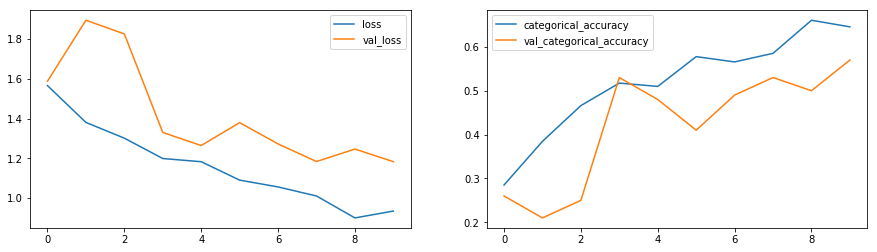

In [47]:
plot(history0_mom)

In [51]:
history0_mom=model0_mom.fit_generator(train_generator0_mom, steps_per_epoch=steps_per_epoch, epochs=25, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator0_mom, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  ./Project_data/val ; batch size = 32
Source path =  ./Project_data/train ; batch size = 32
Epoch 1/25


/mnt/disks/user/anaconda3/lib/python3.6/site-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/mnt/disks/user/anaconda3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


21/21 [==============================] - 66s 3s/step - loss: 1.5600 - categorical_accuracy: 0.3101 - val_loss: 1.6487 - val_categorical_accuracy: 0.2100

Epoch 00001: saving model to model_init_2020-08-1608_53_03.430813/model-00001-1.56371-0.30618-1.64871-0.21000.h5
Epoch 2/25
21/21 [==============================] - 51s 2s/step - loss: 1.4162 - categorical_accuracy: 0.3544 - val_loss: 1.5168 - val_categorical_accuracy: 0.3200

Epoch 00002: saving model to model_init_2020-08-1608_53_03.430813/model-00002-1.41839-0.35445-1.51677-0.32000.h5
Epoch 3/25
21/21 [==============================] - 58s 3s/step - loss: 1.2969 - categorical_accuracy: 0.4223 - val_loss: 1.4275 - val_categorical_accuracy: 0.4200

Epoch 00003: saving model to model_init_2020-08-1608_53_03.430813/model-00003-1.30092-0.41931-1.42755-0.42000.h5
Epoch 4/25
21/21 [==============================] - 53s 3s/step - loss: 1.1475 - categorical_accuracy: 0.5252 - val_loss: 1.2676 - val_categorical_accuracy: 0.4300

Epoch 00004:

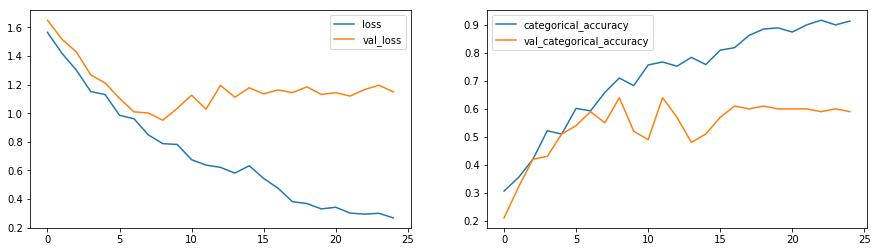

In [52]:
plot(history0_mom)

In [ ]:
#Adding another 16 kernel CNN to check if model learns more

In [54]:
model1 = Sequential()
model1.add(TimeDistributed(Conv2D(16, (3, 3), padding='same', activation='relu'), input_shape=(15, 100, 100, 3)))
model1.add(TimeDistributed(BatchNormalization()))

model1.add(TimeDistributed(MaxPooling2D(pool_size=(2, 2))))

model1.add(TimeDistributed(Conv2D(32, (3, 3), padding='same', activation='relu')))
model1.add(TimeDistributed(BatchNormalization()))

model1.add(TimeDistributed(MaxPooling2D(pool_size=(2, 2))))

model1.add(TimeDistributed(Conv2D(64, (3, 3), padding='same', activation='relu')))
model1.add(TimeDistributed(BatchNormalization()))

model1.add(TimeDistributed(MaxPooling2D(pool_size=(2, 2))))

model1.add(TimeDistributed(Flatten()))

model1.add(LSTM(64))
model1.add(Dropout(0.25))

model1.add(Dense(64, activation='relu'))
model1.add(Dropout(0.25))

model1.add(Dense(5, activation='softmax'))

In [55]:
train_generator1 = generator(train_path, train_doc, batch_size)
val_generator1 = generator(val_path, val_doc, batch_size)

callbacks_list = get_callback_list()

In [56]:
optimiser = optimizers.SGD(lr=0.01, momentum=0.9)
model1.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model1.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_57 (TimeDis (None, 15, 100, 100, 16)  448       
_________________________________________________________________
time_distributed_58 (TimeDis (None, 15, 100, 100, 16)  64        
_________________________________________________________________
time_distributed_59 (TimeDis (None, 15, 50, 50, 16)    0         
_________________________________________________________________
time_distributed_60 (TimeDis (None, 15, 50, 50, 32)    4640      
_________________________________________________________________
time_distributed_61 (TimeDis (None, 15, 50, 50, 32)    128       
_________________________________________________________________
time_distributed_62 (TimeDis (None, 15, 25, 25, 32)    0         
_________________________________________________________________
time_distributed_63 (TimeDis (None, 15, 25, 25, 64)    18496     
__________

In [57]:
history1=model1.fit_generator(train_generator1, steps_per_epoch=steps_per_epoch, epochs=25, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator1, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  ./Project_data/val ; batch size = 32
Source path =  ./Project_data/train ; batch size = 32
Epoch 1/25


/mnt/disks/user/anaconda3/lib/python3.6/site-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/mnt/disks/user/anaconda3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


21/21 [==============================] - 64s 3s/step - loss: 1.5602 - categorical_accuracy: 0.3026 - val_loss: 1.7402 - val_categorical_accuracy: 0.2100

Epoch 00001: saving model to model_init_2020-08-1610_22_08.058259/model-00001-1.56381-0.29864-1.74021-0.21000.h5
Epoch 2/25
21/21 [==============================] - 57s 3s/step - loss: 1.3168 - categorical_accuracy: 0.4236 - val_loss: 1.7910 - val_categorical_accuracy: 0.2300

Epoch 00002: saving model to model_init_2020-08-1610_22_08.058259/model-00002-1.31936-0.42232-1.79099-0.23000.h5
Epoch 3/25
21/21 [==============================] - 51s 2s/step - loss: 1.1658 - categorical_accuracy: 0.5096 - val_loss: 1.7800 - val_categorical_accuracy: 0.3200

Epoch 00003: saving model to model_init_2020-08-1610_22_08.058259/model-00003-1.16813-0.50830-1.77998-0.32000.h5
Epoch 4/25
21/21 [==============================] - 60s 3s/step - loss: 1.0759 - categorical_accuracy: 0.5384 - val_loss: 1.8726 - val_categorical_accuracy: 0.2900

Epoch 00004:

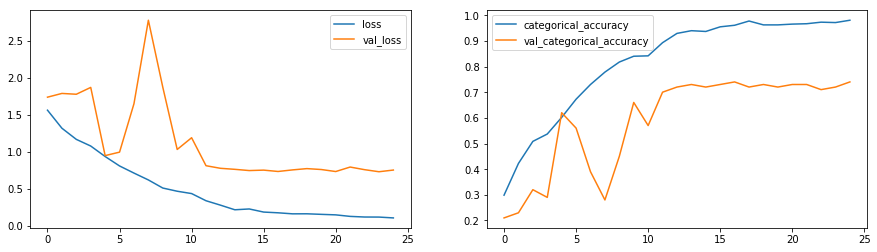

In [58]:
plot(history1)

In [ ]:
# Same model using GRU

In [18]:
model2 = Sequential()
model2.add(TimeDistributed(Conv2D(16, (3, 3), padding='same', activation='relu'), input_shape=(15, 100, 100, 3)))
model2.add(TimeDistributed(BatchNormalization()))

model2.add(TimeDistributed(MaxPooling2D(pool_size=(2, 2))))

model2.add(TimeDistributed(Conv2D(32, (3, 3), padding='same', activation='relu')))
model2.add(TimeDistributed(BatchNormalization()))

model2.add(TimeDistributed(MaxPooling2D(pool_size=(2, 2))))

model2.add(TimeDistributed(Conv2D(64, (3, 3), padding='same', activation='relu')))
model2.add(TimeDistributed(BatchNormalization()))

model2.add(TimeDistributed(MaxPooling2D(pool_size=(2, 2))))

model2.add(TimeDistributed(Flatten()))

model2.add(GRU(64))
model2.add(Dropout(0.25))

model2.add(Dense(64, activation='relu'))
#model2.add(Dense(64, activation='relu', kernel_regularizer='l2'))
model2.add(Dropout(0.25))

model2.add(Dense(5, activation='softmax'))

In [19]:
train_generator2 = generator(train_path, train_doc, batch_size)
val_generator2 = generator(val_path, val_doc, batch_size)

callbacks_list = get_callback_list()

In [20]:
optimiser = optimizers.SGD(lr=0.01, momentum=0.9)
model2.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model2.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_11 (TimeDis (None, 15, 100, 100, 16)  448       
_________________________________________________________________
time_distributed_12 (TimeDis (None, 15, 100, 100, 16)  64        
_________________________________________________________________
time_distributed_13 (TimeDis (None, 15, 50, 50, 16)    0         
_________________________________________________________________
time_distributed_14 (TimeDis (None, 15, 50, 50, 32)    4640      
_________________________________________________________________
time_distributed_15 (TimeDis (None, 15, 50, 50, 32)    128       
_________________________________________________________________
time_distributed_16 (TimeDis (None, 15, 25, 25, 32)    0         
_________________________________________________________________
time_distributed_17 (TimeDis (None, 15, 25, 25, 64)    18496     
__________

In [16]:
history2=model2.fit_generator(train_generator2, steps_per_epoch=steps_per_epoch, epochs=25, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator2, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  ./Project_data/val ; batch size = 32
Source path =  ./Project_data/trainEpoch 1/25
 ; batch size = 32


/mnt/disks/user/anaconda3/lib/python3.6/site-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/mnt/disks/user/anaconda3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


21/21 [==============================] - 139s 7s/step - loss: 1.5671 - categorical_accuracy: 0.3052 - val_loss: 1.5998 - val_categorical_accuracy: 0.4000

Epoch 00001: saving model to model_init_2020-08-1611_13_29.647641/model-00001-1.57049-0.30468-1.59984-0.40000.h5
Epoch 2/25
21/21 [==============================] - 54s 3s/step - loss: 1.3075 - categorical_accuracy: 0.4350 - val_loss: 1.8933 - val_categorical_accuracy: 0.3200

Epoch 00002: saving model to model_init_2020-08-1611_13_29.647641/model-00002-1.30847-0.43439-1.89327-0.32000.h5
Epoch 3/25
21/21 [==============================] - 52s 2s/step - loss: 1.1096 - categorical_accuracy: 0.5325 - val_loss: 1.1161 - val_categorical_accuracy: 0.5200

Epoch 00003: saving model to model_init_2020-08-1611_13_29.647641/model-00003-1.11123-0.53092-1.11613-0.52000.h5
Epoch 4/25
21/21 [==============================] - 59s 3s/step - loss: 1.0083 - categorical_accuracy: 0.5583 - val_loss: 1.1763 - val_categorical_accuracy: 0.5500

Epoch 00004

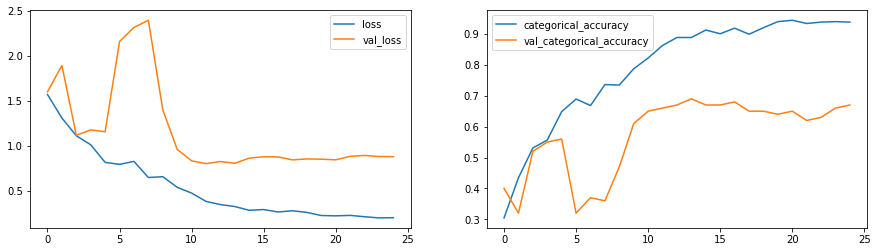

In [17]:
plot(history2)

In [ ]:
#L2 regularization in dense

In [21]:
history2_l2=model2.fit_generator(train_generator2, steps_per_epoch=steps_per_epoch, epochs=20, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator2, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  ./Project_data/val ; batch size = 32
Source path =  ./Project_data/train ; batch size = 32
Epoch 1/20


/mnt/disks/user/anaconda3/lib/python3.6/site-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/mnt/disks/user/anaconda3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


21/21 [==============================] - 68s 3s/step - loss: 2.2279 - categorical_accuracy: 0.2775 - val_loss: 2.2050 - val_categorical_accuracy: 0.3500

Epoch 00001: saving model to model_init_2020-08-1611_39_38.386242/model-00001-2.23127-0.27602-2.20501-0.35000.h5
Epoch 2/20
21/21 [==============================] - 50s 2s/step - loss: 1.8900 - categorical_accuracy: 0.4448 - val_loss: 2.0630 - val_categorical_accuracy: 0.4000

Epoch 00002: saving model to model_init_2020-08-1611_39_38.386242/model-00002-1.89079-0.44495-2.06295-0.40000.h5
Epoch 3/20
21/21 [==============================] - 52s 2s/step - loss: 1.6702 - categorical_accuracy: 0.4973 - val_loss: 2.2494 - val_categorical_accuracy: 0.3400

Epoch 00003: saving model to model_init_2020-08-1611_39_38.386242/model-00003-1.67435-0.49472-2.24935-0.34000.h5
Epoch 4/20
21/21 [==============================] - 54s 3s/step - loss: 1.5064 - categorical_accuracy: 0.5611 - val_loss: 1.7755 - val_categorical_accuracy: 0.4100

Epoch 00004:

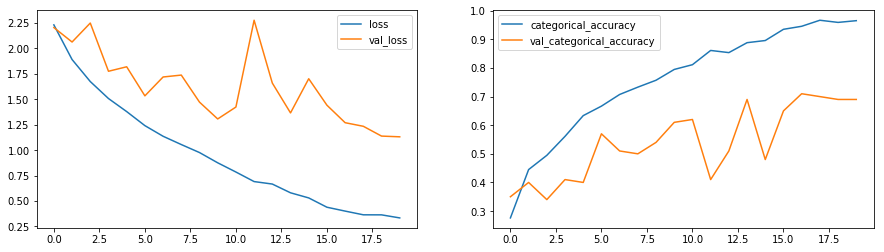

In [22]:
plot(history2_l2)

In [ ]:
#Trying with bigger filter in second layer

In [23]:
model3 = Sequential()
model3.add(TimeDistributed(Conv2D(32, (3, 3), padding='same', activation='relu'), input_shape=(15, 100, 100, 3)))
model3.add(TimeDistributed(BatchNormalization()))

model3.add(TimeDistributed(MaxPooling2D(pool_size=(2, 2))))

model3.add(TimeDistributed(Conv2D(64, (5, 5), padding='same', activation='relu')))
model3.add(TimeDistributed(BatchNormalization()))

model3.add(TimeDistributed(MaxPooling2D(pool_size=(2, 2))))

model3.add(TimeDistributed(Flatten()))

model3.add(LSTM(64))
model3.add(Dropout(0.25))

model3.add(Dense(64, activation='relu'))
model3.add(Dropout(0.25))

model3.add(Dense(5, activation='softmax'))

In [24]:
train_generator3 = generator(train_path, train_doc, batch_size)
val_generator3 = generator(val_path, val_doc, batch_size)

callbacks_list = get_callback_list()

In [25]:
optimiser = optimizers.SGD(lr=0.01, momentum=0.9)
model3.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model3.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_21 (TimeDis (None, 15, 100, 100, 32)  896       
_________________________________________________________________
time_distributed_22 (TimeDis (None, 15, 100, 100, 32)  128       
_________________________________________________________________
time_distributed_23 (TimeDis (None, 15, 50, 50, 32)    0         
_________________________________________________________________
time_distributed_24 (TimeDis (None, 15, 50, 50, 64)    51264     
_________________________________________________________________
time_distributed_25 (TimeDis (None, 15, 50, 50, 64)    256       
_________________________________________________________________
time_distributed_26 (TimeDis (None, 15, 25, 25, 64)    0         
_________________________________________________________________
time_distributed_27 (TimeDis (None, 15, 40000)         0         
__________

In [26]:
history3=model3.fit_generator(train_generator3, steps_per_epoch=steps_per_epoch, epochs=15, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator3, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  ./Project_data/val ; batch size = 32
Source path =  Epoch 1/15
./Project_data/train ; batch size = 32


/mnt/disks/user/anaconda3/lib/python3.6/site-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/mnt/disks/user/anaconda3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


21/21 [==============================] - 70s 3s/step - loss: 1.5332 - categorical_accuracy: 0.2994 - val_loss: 1.4661 - val_categorical_accuracy: 0.3800

Epoch 00001: saving model to model_init_2020-08-1612_04_21.520639/model-00001-1.53466-0.29713-1.46615-0.38000.h5
Epoch 2/15
21/21 [==============================] - 56s 3s/step - loss: 1.3760 - categorical_accuracy: 0.4081 - val_loss: 1.4300 - val_categorical_accuracy: 0.4200

Epoch 00002: saving model to model_init_2020-08-1612_04_21.520639/model-00002-1.37925-0.40724-1.43002-0.42000.h5
Epoch 3/15
21/21 [==============================] - 57s 3s/step - loss: 1.2729 - categorical_accuracy: 0.4703 - val_loss: 1.2962 - val_categorical_accuracy: 0.4700

Epoch 00003: saving model to model_init_2020-08-1612_04_21.520639/model-00003-1.27450-0.46908-1.29616-0.47000.h5
Epoch 4/15
21/21 [==============================] - 58s 3s/step - loss: 1.1841 - categorical_accuracy: 0.5185 - val_loss: 1.1787 - val_categorical_accuracy: 0.4900

Epoch 00004:

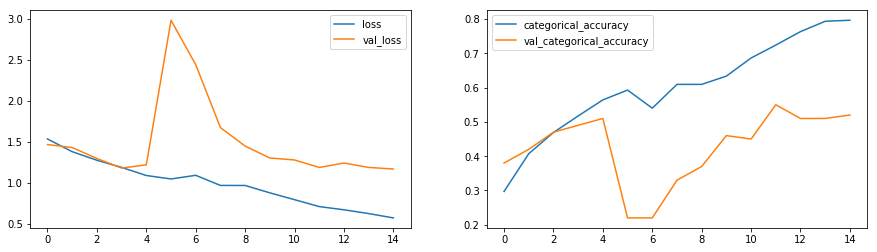

In [27]:
plot(history3)

In [32]:
## Transfer learning with VGG net

In [29]:
vgg = VGG16(include_top=False, weights='imagenet', input_shape=(100,100,3))

for layer in vgg.layers:
    layer.trainable = False
    
model_vgg = Sequential()
model_vgg.add(TimeDistributed(vgg, input_shape=(15, 100,100,3)))
model_vgg.add(TimeDistributed(Flatten()))

model_vgg.add(GRU(64))

model_vgg.add(Dense(64, activation='relu'))

model_vgg.add(Dense(5, activation='softmax'))

In [30]:
optimiser = optimizers.SGD(lr=0.01)
model_vgg.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print(model_vgg.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_30 (TimeDis (None, 15, 3, 3, 512)     14714688  
_________________________________________________________________
time_distributed_31 (TimeDis (None, 15, 4608)          0         
_________________________________________________________________
gru_4 (GRU)                  (None, 64)                897216    
_________________________________________________________________
dense_9 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_10 (Dense)             (None, 5)                 325       
Total params: 15,616,389
Trainable params: 901,701
Non-trainable params: 14,714,688
_________________________________________________________________
None


In [31]:
train_generator_vgg = generator(train_path, train_doc, batch_size)
val_generator_vgg = generator(val_path, val_doc, batch_size)

callbacks_list = get_callback_list()

history_vgg=model_vgg.fit_generator(train_generator_vgg, steps_per_epoch=steps_per_epoch, epochs=15, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator_vgg, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path = Source path =  ./Project_data/val ; batch size = 32
Epoch 1/15 ./Project_data/train 
; batch size = 32


/mnt/disks/user/anaconda3/lib/python3.6/site-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/mnt/disks/user/anaconda3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


21/21 [==============================] - 77s 4s/step - loss: 1.6155 - categorical_accuracy: 0.2564 - val_loss: 1.5125 - val_categorical_accuracy: 0.2800

Epoch 00001: saving model to model_init_2020-08-1612_25_20.616865/model-00001-1.61799-0.25189-1.51254-0.28000.h5
Epoch 2/15
21/21 [==============================] - 50s 2s/step - loss: 1.4973 - categorical_accuracy: 0.3493 - val_loss: 1.4539 - val_categorical_accuracy: 0.3700

Epoch 00002: saving model to model_init_2020-08-1612_25_20.616865/model-00002-1.49912-0.34540-1.45387-0.37000.h5
Epoch 3/15
21/21 [==============================] - 56s 3s/step - loss: 1.4002 - categorical_accuracy: 0.4253 - val_loss: 1.4084 - val_categorical_accuracy: 0.4000

Epoch 00003: saving model to model_init_2020-08-1612_25_20.616865/model-00003-1.40248-0.42232-1.40843-0.40000.h5
Epoch 4/15
21/21 [==============================] - 61s 3s/step - loss: 1.3183 - categorical_accuracy: 0.4656 - val_loss: 1.3493 - val_categorical_accuracy: 0.4500

Epoch 00004:

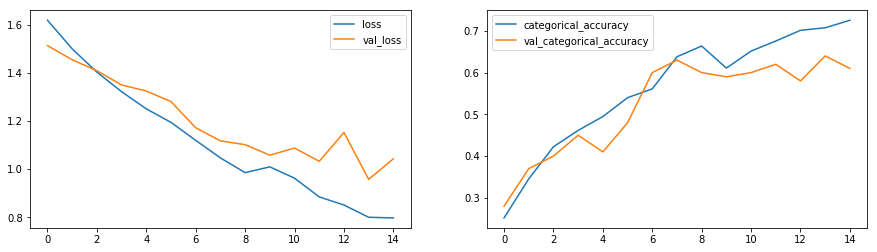

In [33]:
plot(history_vgg)

In [34]:
vgg = VGG16(include_top=False, weights='imagenet', input_shape=(100,100,3))

for layer in vgg.layers:
    layer.trainable = False
    
model_vgg_dr = Sequential()
model_vgg_dr.add(TimeDistributed(vgg, input_shape=(15, 100,100,3)))
model_vgg_dr.add(TimeDistributed(Flatten()))

model_vgg_dr.add(GRU(64))
model_vgg_dr.add(Dropout(0.25))

model_vgg_dr.add(Dense(64, activation='relu'))
model_vgg_dr.add(Dropout(0.25))

model_vgg_dr.add(Dense(5, activation='softmax'))

In [35]:
optimiser = optimizers.SGD(lr=0.01)
model_vgg_dr.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print(model_vgg_dr.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_32 (TimeDis (None, 15, 3, 3, 512)     14714688  
_________________________________________________________________
time_distributed_33 (TimeDis (None, 15, 4608)          0         
_________________________________________________________________
gru_5 (GRU)                  (None, 64)                897216    
_________________________________________________________________
dropout_7 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_11 (Dense)             (None, 64)                4160      
_________________________________________________________________
dropout_8 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_12 (Dense)             (None, 5)                 325       
Total para

In [36]:
train_generator_vgg_dr = generator(train_path, train_doc, batch_size)
val_generator_vgg_dr = generator(val_path, val_doc, batch_size)

callbacks_list = get_callback_list()

history_vgg_dr=model_vgg_dr.fit_generator(train_generator_vgg_dr, steps_per_epoch=steps_per_epoch, epochs=30,
                                          verbose=1, callbacks=callbacks_list, validation_data=val_generator_vgg_dr, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  ./Project_data/val ; batch size = 32
Source path =  ./Project_data/train ; batch size = 32
Epoch 1/30


/mnt/disks/user/anaconda3/lib/python3.6/site-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/mnt/disks/user/anaconda3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


21/21 [==============================] - 69s 3s/step - loss: 1.6791 - categorical_accuracy: 0.2098 - val_loss: 1.5979 - val_categorical_accuracy: 0.2400

Epoch 00001: saving model to model_init_2020-08-1612_42_33.036125/model-00001-1.68018-0.20965-1.59791-0.24000.h5
Epoch 2/30
21/21 [==============================] - 55s 3s/step - loss: 1.6021 - categorical_accuracy: 0.2477 - val_loss: 1.5564 - val_categorical_accuracy: 0.2400

Epoch 00002: saving model to model_init_2020-08-1612_42_33.036125/model-00002-1.60385-0.24585-1.55638-0.24000.h5
Epoch 3/30
21/21 [==============================] - 60s 3s/step - loss: 1.5639 - categorical_accuracy: 0.2933 - val_loss: 1.5254 - val_categorical_accuracy: 0.2600

Epoch 00003: saving model to model_init_2020-08-1612_42_33.036125/model-00003-1.56491-0.29261-1.52542-0.26000.h5
Epoch 4/30
21/21 [==============================] - 58s 3s/step - loss: 1.5121 - categorical_accuracy: 0.3138 - val_loss: 1.4887 - val_categorical_accuracy: 0.2800

Epoch 00004:

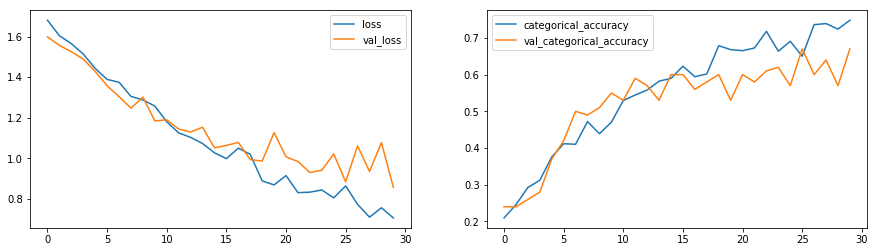

In [37]:
plot(history_vgg_dr)

In [ ]:
#Training last three layers of VGGNet

In [41]:
vgg_t = VGG16(include_top=False, weights='imagenet', input_shape=(100,100,3))

for layer in vgg_t.layers[:-3]:
    layer.trainable = False
for layer in vgg_t.layers[-3:]:
    layer.trainable = True
    
model_vgg_t = Sequential()
model_vgg_t.add(TimeDistributed(vgg_t, input_shape=(15, 100,100,3)))
model_vgg_t.add(TimeDistributed(Flatten()))

model_vgg_t.add(GRU(64))
# model_vgg_t.add(Dropout(0.25))

model_vgg_t.add(Dense(64, activation='relu'))
# model_vgg_t.add(Dropout(0.25))

model_vgg_t.add(Dense(5, activation='softmax'))

In [42]:
optimiser = optimizers.SGD(lr=0.01)
model_vgg_t.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print(model_vgg_t.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_38 (TimeDis (None, 15, 3, 3, 512)     14714688  
_________________________________________________________________
time_distributed_39 (TimeDis (None, 15, 4608)          0         
_________________________________________________________________
gru_8 (GRU)                  (None, 64)                897216    
_________________________________________________________________
dense_17 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_18 (Dense)             (None, 5)                 325       
Total params: 15,616,389
Trainable params: 5,621,317
Non-trainable params: 9,995,072
_________________________________________________________________
None


In [43]:
train_generator_vgg_t = generator(train_path, train_doc, batch_size)
val_generator_vgg_t = generator(val_path, val_doc, batch_size)

callbacks_list = get_callback_list()

history_vgg_t=model_vgg_t.fit_generator(train_generator_vgg_t, steps_per_epoch=steps_per_epoch, epochs=15,
                                          verbose=1, callbacks=callbacks_list, validation_data=val_generator_vgg_t, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  ./Project_data/val ; batch size = 32
Source path =  ./Project_data/train ; batch size =Epoch 1/15
 32


/mnt/disks/user/anaconda3/lib/python3.6/site-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/mnt/disks/user/anaconda3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


21/21 [==============================] - 73s 3s/step - loss: 1.5739 - categorical_accuracy: 0.2799 - val_loss: 1.4898 - val_categorical_accuracy: 0.3500

Epoch 00001: saving model to model_init_2020-08-1613_15_31.549988/model-00001-1.57467-0.27903-1.48983-0.35000.h5
Epoch 2/15
21/21 [==============================] - 57s 3s/step - loss: 1.3263 - categorical_accuracy: 0.4936 - val_loss: 1.4685 - val_categorical_accuracy: 0.3900

Epoch 00002: saving model to model_init_2020-08-1613_15_31.549988/model-00002-1.32854-0.49321-1.46847-0.39000.h5
Epoch 3/15
21/21 [==============================] - 61s 3s/step - loss: 1.1028 - categorical_accuracy: 0.5913 - val_loss: 1.1702 - val_categorical_accuracy: 0.5300

Epoch 00003: saving model to model_init_2020-08-1613_15_31.549988/model-00003-1.10656-0.58824-1.17020-0.53000.h5
Epoch 4/15
21/21 [==============================] - 62s 3s/step - loss: 0.9688 - categorical_accuracy: 0.6425 - val_loss: 1.1206 - val_categorical_accuracy: 0.5700

Epoch 00004:

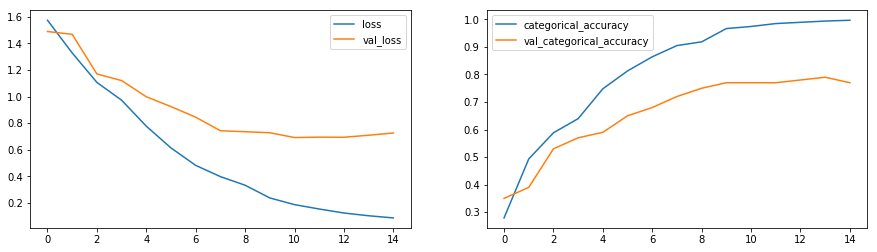

In [44]:
plot(history_vgg_t)

In [45]:
vgg_t_dr = VGG16(include_top=False, weights='imagenet', input_shape=(100,100,3))

for layer in vgg_t_dr.layers[:-3]:
    layer.trainable = False
for layer in vgg_t_dr.layers[-3:]:
    layer.trainable = True
    
model_vgg_t_dr = Sequential()
model_vgg_t_dr.add(TimeDistributed(vgg_t_dr, input_shape=(15, 100,100,3)))
model_vgg_t_dr.add(TimeDistributed(Flatten()))

model_vgg_t_dr.add(GRU(64))
model_vgg_t_dr.add(Dropout(0.25))

model_vgg_t_dr.add(Dense(64, activation='relu'))
model_vgg_t_dr.add(Dropout(0.25))

model_vgg_t_dr.add(Dense(5, activation='softmax'))

In [46]:
optimiser = optimizers.SGD(lr=0.01)
model_vgg_t_dr.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print(model_vgg_t_dr.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_40 (TimeDis (None, 15, 3, 3, 512)     14714688  
_________________________________________________________________
time_distributed_41 (TimeDis (None, 15, 4608)          0         
_________________________________________________________________
gru_9 (GRU)                  (None, 64)                897216    
_________________________________________________________________
dropout_11 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_19 (Dense)             (None, 64)                4160      
_________________________________________________________________
dropout_12 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_20 (Dense)             (None, 5)                 325       
Total para

In [47]:
train_generator_vgg_t_dr = generator(train_path, train_doc, batch_size)
val_generator_vgg_t_dr = generator(val_path, val_doc, batch_size)

callbacks_list = get_callback_list()

history_vgg_t_dr=model_vgg_t_dr.fit_generator(train_generator_vgg_t_dr, steps_per_epoch=steps_per_epoch, epochs=20,
                                          verbose=1, callbacks=callbacks_list, validation_data=val_generator_vgg_t_dr, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  ./Project_data/val ; batch size = 32
Source path =  ./Project_data/train ; batch size = 32
Epoch 1/20


/mnt/disks/user/anaconda3/lib/python3.6/site-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/mnt/disks/user/anaconda3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


21/21 [==============================] - 69s 3s/step - loss: 1.6475 - categorical_accuracy: 0.2388 - val_loss: 1.4765 - val_categorical_accuracy: 0.2600

Epoch 00001: saving model to model_init_2020-08-1613_31_58.089966/model-00001-1.65056-0.23680-1.47650-0.26000.h5
Epoch 2/20
21/21 [==============================] - 58s 3s/step - loss: 1.4607 - categorical_accuracy: 0.3674 - val_loss: 1.4295 - val_categorical_accuracy: 0.3500

Epoch 00002: saving model to model_init_2020-08-1613_31_58.089966/model-00002-1.46231-0.36652-1.42946-0.35000.h5
Epoch 3/20
21/21 [==============================] - 58s 3s/step - loss: 1.3136 - categorical_accuracy: 0.4610 - val_loss: 1.3724 - val_categorical_accuracy: 0.3800

Epoch 00003: saving model to model_init_2020-08-1613_31_58.089966/model-00003-1.31542-0.45852-1.37236-0.38000.h5
Epoch 4/20
21/21 [==============================] - 60s 3s/step - loss: 1.1005 - categorical_accuracy: 0.5747 - val_loss: 1.1354 - val_categorical_accuracy: 0.5200

Epoch 00004:

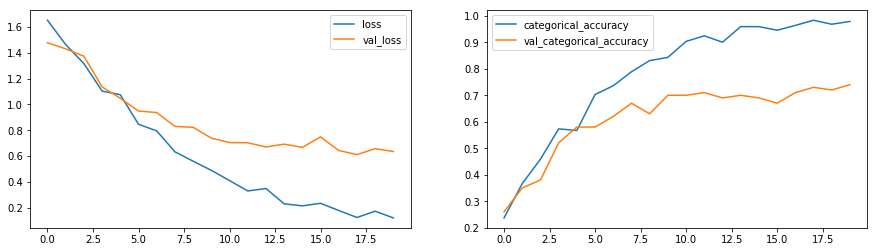

In [48]:
plot(history_vgg_t_dr)

In [51]:
vgg_t_reg = VGG16(include_top=False, weights='imagenet', input_shape=(100,100,3))

for layer in vgg_t_reg.layers[:-3]:
    layer.trainable = False
for layer in vgg_t_reg.layers[-3:]:
    layer.trainable = True
    
model_vgg_t_reg = Sequential()
model_vgg_t_reg.add(TimeDistributed(vgg_t_reg, input_shape=(15, 100,100,3)))
model_vgg_t_reg.add(TimeDistributed(Flatten()))

model_vgg_t_reg.add(GRU(64))
model_vgg_t_reg.add(Dropout(0.25))

model_vgg_t_reg.add(Dense(64, activation='relu', kernel_regularizer='l2'))

model_vgg_t_reg.add(Dense(5, activation='softmax'))

In [52]:
optimiser = optimizers.SGD(lr=0.01)
model_vgg_t_reg.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print(model_vgg_t_reg.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_44 (TimeDis (None, 15, 3, 3, 512)     14714688  
_________________________________________________________________
time_distributed_45 (TimeDis (None, 15, 4608)          0         
_________________________________________________________________
gru_11 (GRU)                 (None, 64)                897216    
_________________________________________________________________
dropout_13 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_23 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_24 (Dense)             (None, 5)                 325       
Total params: 15,616,389
Trainable params: 5,621,317
Non-trainable params: 9,995,072
_________________________________________________________

In [53]:
train_generator_vgg_t_reg = generator(train_path, train_doc, batch_size)
val_generator_vgg_t_reg = generator(val_path, val_doc, batch_size)

callbacks_list = get_callback_list()

history_vgg_t_reg=model_vgg_t_reg.fit_generator(train_generator_vgg_t_reg, steps_per_epoch=steps_per_epoch, epochs=20,
                                          verbose=1, callbacks=callbacks_list, validation_data=val_generator_vgg_t_reg, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  ./Project_data/val ; batch size = 32
Source path =  ./Project_data/train ; batch size = 32
Epoch 1/20


/mnt/disks/user/anaconda3/lib/python3.6/site-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/mnt/disks/user/anaconda3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


21/21 [==============================] - 72s 3s/step - loss: 2.2451 - categorical_accuracy: 0.2924 - val_loss: 2.0835 - val_categorical_accuracy: 0.4200

Epoch 00001: saving model to model_init_2020-08-1613_59_35.466339/model-00001-2.24615-0.29110-2.08350-0.42000.h5
Epoch 2/20
21/21 [==============================] - 59s 3s/step - loss: 2.0602 - categorical_accuracy: 0.4052 - val_loss: 1.9815 - val_categorical_accuracy: 0.3800

Epoch 00002: saving model to model_init_2020-08-1613_59_35.466339/model-00002-2.06218-0.40422-1.98148-0.38000.h5
Epoch 3/20
21/21 [==============================] - 60s 3s/step - loss: 1.8911 - categorical_accuracy: 0.5230 - val_loss: 1.8550 - val_categorical_accuracy: 0.5500

Epoch 00003: saving model to model_init_2020-08-1613_59_35.466339/model-00003-1.89415-0.52187-1.85505-0.55000.h5
Epoch 4/20
21/21 [==============================] - 59s 3s/step - loss: 1.6718 - categorical_accuracy: 0.6190 - val_loss: 1.7258 - val_categorical_accuracy: 0.5600

Epoch 00004:

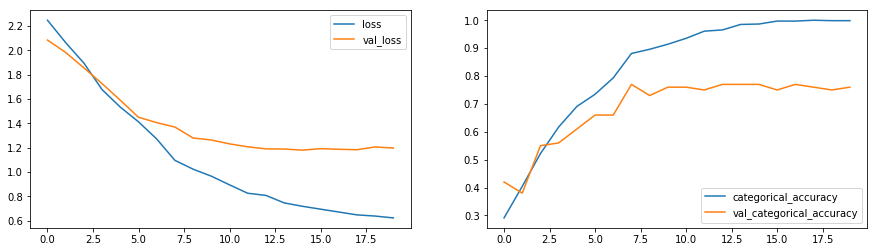

In [54]:
plot(history_vgg_t_reg)

In [ ]:
#Good model

## Conv3D

In [ ]:
#Starting with a basic architecture 

In [20]:
model1 = Sequential()
model1.add(Conv3D(16,(3,3,3),activation='relu',input_shape=(15,100,100,3)))
model1.add(BatchNormalization())

model1.add(MaxPooling3D(pool_size=(1, 2, 2)))
model1.add(Dropout(0.25))

model1.add(Conv3D(32,(3,3,3), activation='relu'))
model1.add(BatchNormalization())
model1.add(MaxPooling3D(pool_size=(2, 2, 2)))
model1.add(Dropout(0.25))

model1.add(Conv3D(64,(3,3,3), activation='relu'))
model1.add(BatchNormalization())
model1.add(MaxPooling3D(pool_size=(1, 1, 4 )))

model1.add(Flatten())
model1.add(Dense(64, activation='relu'))
model1.add(Dropout(0.25))

model1.add(Dense(5,kernel_initializer='normal'))

model1.add(Activation('softmax'))

In [21]:
optimiser = optimizers.SGD(lr=0.01)
model1.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print(model1.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_4 (Conv3D)            (None, 13, 98, 98, 16)    1312      
_________________________________________________________________
batch_normalization_6 (Batch (None, 13, 98, 98, 16)    64        
_________________________________________________________________
max_pooling3d_4 (MaxPooling3 (None, 13, 49, 49, 16)    0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 13, 49, 49, 16)    0         
_________________________________________________________________
conv3d_5 (Conv3D)            (None, 11, 47, 47, 32)    13856     
_________________________________________________________________
batch_normalization_7 (Batch (None, 11, 47, 47, 32)    128       
_________________________________________________________________
max_pooling3d_5 (MaxPooling3 (None, 5, 23, 23, 32)     0         
__________

In [27]:
train_generator_1 = generator(train_path, train_doc, batch_size)
val_generator_1 = generator(val_path, val_doc, batch_size)

callbacks_list = get_callback_list()

history_1=model1.fit_generator(train_generator_1, steps_per_epoch=steps_per_epoch, epochs=15,
                                          verbose=1, callbacks=callbacks_list, validation_data=val_generator_1, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  ./Project_data/val ; batch size = 32
Source path =  ./Project_data/train ; batch size = 32
Epoch 1/15


/mnt/disks/user/anaconda3/lib/python3.6/site-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/mnt/disks/user/anaconda3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


21/21 [==============================] - 68s 3s/step - loss: 0.8956 - categorical_accuracy: 0.6330 - val_loss: 1.2391 - val_categorical_accuracy: 0.5000

Epoch 00001: saving model to model_init_2020-08-1617_53_15.045688/model-00001-0.89814-0.63047-1.23911-0.50000.h5
Epoch 2/15
21/21 [==============================] - 55s 3s/step - loss: 0.8393 - categorical_accuracy: 0.6536 - val_loss: 1.2122 - val_categorical_accuracy: 0.5100

Epoch 00002: saving model to model_init_2020-08-1617_53_15.045688/model-00002-0.84116-0.65309-1.21224-0.51000.h5
Epoch 3/15
21/21 [==============================] - 53s 3s/step - loss: 0.7484 - categorical_accuracy: 0.6823 - val_loss: 1.0616 - val_categorical_accuracy: 0.5200

Epoch 00003: saving model to model_init_2020-08-1617_53_15.045688/model-00003-0.74918-0.68326-1.06160-0.52000.h5
Epoch 4/15
21/21 [==============================] - 61s 3s/step - loss: 0.6858 - categorical_accuracy: 0.7219 - val_loss: 1.8744 - val_categorical_accuracy: 0.3700

Epoch 00004:

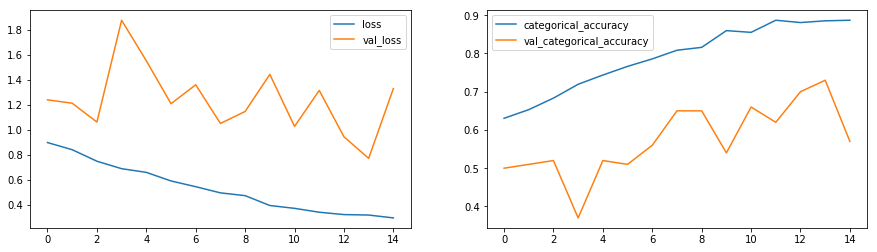

In [28]:
plot(history_1)

In [ ]:
#Val_loss curve fluctuates a lot, low accuracy

In [ ]:
#Model 2 - Adding another Conv3D layer 

In [29]:
model_2 = Sequential()

model_2.add(Conv3D(16,(3,3,3),activation='relu',input_shape=(15,100,100,3)))
model_2.add(BatchNormalization())
model_2.add(Conv3D(16,(3,3,3),activation='relu'))
model_2.add(BatchNormalization())
model_2.add(MaxPooling3D(pool_size=(1, 2, 2)))
model_2.add(Dropout(0.25))

model_2.add(Conv3D(32,(3,3,3), activation='relu'))
model_2.add(BatchNormalization())
model_2.add(MaxPooling3D(pool_size=(2, 2, 2)))
model_2.add(Conv3D(64,(3,3,3), activation='relu'))
model_2.add(BatchNormalization())
model_2.add(MaxPooling3D(pool_size=(1, 1, 4 )))
model_2.add(Dropout(0.25))

model_2.add(Flatten())
model_2.add(Dense(512, activation='relu'))
model_2.add(Dropout(0.5))

model_2.add(Dense(256, activation='relu'))
model_2.add(Dropout(0.5))

model_2.add(Dense(5,kernel_initializer='normal'))

model_2.add(Activation('softmax'))

In [30]:
optimiser = optimizers.SGD(lr=0.001,momentum=0.9)
model_2.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print(model_2.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_7 (Conv3D)            (None, 13, 98, 98, 16)    1312      
_________________________________________________________________
batch_normalization_9 (Batch (None, 13, 98, 98, 16)    64        
_________________________________________________________________
conv3d_8 (Conv3D)            (None, 11, 96, 96, 16)    6928      
_________________________________________________________________
batch_normalization_10 (Batc (None, 11, 96, 96, 16)    64        
_________________________________________________________________
max_pooling3d_7 (MaxPooling3 (None, 11, 48, 48, 16)    0         
_________________________________________________________________
dropout_7 (Dropout)          (None, 11, 48, 48, 16)    0         
_________________________________________________________________
conv3d_9 (Conv3D)            (None, 9, 46, 46, 32)     13856     
__________

In [31]:
train_generator_2 = generator(train_path, train_doc, batch_size)
val_generator_2 = generator(val_path, val_doc, batch_size)

callbacks_list = get_callback_list()

history_2=model_2.fit_generator(train_generator_2, steps_per_epoch=steps_per_epoch, epochs=20,
                                          verbose=1, callbacks=callbacks_list, validation_data=val_generator_2, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path = Source path =  ./Project_data/train ; batch size = 32
 Epoch 1/20
./Project_data/val ; batch size = 32


/mnt/disks/user/anaconda3/lib/python3.6/site-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/mnt/disks/user/anaconda3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


21/21 [==============================] - 69s 3s/step - loss: 2.1759 - categorical_accuracy: 0.2937 - val_loss: 1.2517 - val_categorical_accuracy: 0.5100

Epoch 00001: saving model to model_init_2020-08-1618_09_37.102928/model-00001-2.18796-0.28959-1.25165-0.51000.h5
Epoch 2/20
21/21 [==============================] - 53s 3s/step - loss: 1.5441 - categorical_accuracy: 0.3959 - val_loss: 1.0771 - val_categorical_accuracy: 0.5700

Epoch 00002: saving model to model_init_2020-08-1618_09_37.102928/model-00002-1.55241-0.39367-1.07706-0.57000.h5
Epoch 3/20
21/21 [==============================] - 55s 3s/step - loss: 1.2233 - categorical_accuracy: 0.4835 - val_loss: 1.1164 - val_categorical_accuracy: 0.5200

Epoch 00003: saving model to model_init_2020-08-1618_09_37.102928/model-00003-1.23062-0.47964-1.11639-0.52000.h5
Epoch 4/20
21/21 [==============================] - 58s 3s/step - loss: 1.0845 - categorical_accuracy: 0.5380 - val_loss: 0.9557 - val_categorical_accuracy: 0.6600

Epoch 00004:

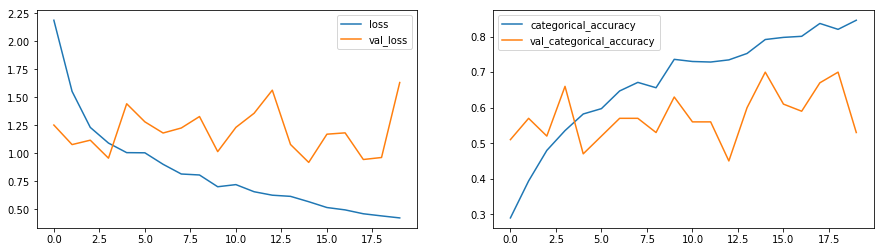

In [32]:
plot(history_2)

In [ ]:
#Model 3

In [33]:
model_3 = Sequential()

model_3.add(Conv3D(16,(5,5,5),activation='relu',input_shape=(15,100,100,3)))
model_3.add(BatchNormalization())
model_3.add(MaxPooling3D(pool_size=(1, 2, 2)))

model_3.add(Conv3D(32,(3,5,5), activation='relu'))
model_3.add(BatchNormalization())
model_3.add(MaxPooling3D(pool_size=(2, 2, 2)))

model_3.add(Conv3D(64,(3,3,5), activation='relu'))
model_3.add(BatchNormalization())
model_3.add(MaxPooling3D(pool_size=(1, 1, 4 )))

model_3.add(Flatten())

model_3.add(Dense(512, activation='relu'))
model_3.add(Dropout(0.5))

model_3.add(Dense(256, activation='relu'))
model_3.add(Dropout(0.5))

model_3.add(Dense(5,kernel_initializer='normal'))

model_3.add(Activation('softmax'))

In [34]:
optimiser = optimizers.SGD(lr=0.001,momentum=0.9)
model_3.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print(model_3.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_11 (Conv3D)           (None, 11, 96, 96, 16)    6016      
_________________________________________________________________
batch_normalization_13 (Batc (None, 11, 96, 96, 16)    64        
_________________________________________________________________
max_pooling3d_10 (MaxPooling (None, 11, 48, 48, 16)    0         
_________________________________________________________________
conv3d_12 (Conv3D)           (None, 9, 44, 44, 32)     38432     
_________________________________________________________________
batch_normalization_14 (Batc (None, 9, 44, 44, 32)     128       
_________________________________________________________________
max_pooling3d_11 (MaxPooling (None, 4, 22, 22, 32)     0         
_________________________________________________________________
conv3d_13 (Conv3D)           (None, 2, 20, 18, 64)     92224     
__________

In [35]:
train_generator_3 = generator(train_path, train_doc, batch_size)
val_generator_3 = generator(val_path, val_doc, batch_size)

callbacks_list = get_callback_list()

history_3=model_3.fit_generator(train_generator_3, steps_per_epoch=steps_per_epoch, epochs=20,
                                          verbose=1, callbacks=callbacks_list, validation_data=val_generator_3, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  ./Project_data/val ; batch size = 32
Source path =  ./Project_data/train ; batch size = 32
Epoch 1/20


/mnt/disks/user/anaconda3/lib/python3.6/site-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/mnt/disks/user/anaconda3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


21/21 [==============================] - 64s 3s/step - loss: 2.0086 - categorical_accuracy: 0.2637 - val_loss: 3.7905 - val_categorical_accuracy: 0.2100

Epoch 00001: saving model to model_init_2020-08-1618_32_06.106537/model-00001-2.01346-0.26546-3.79052-0.21000.h5
Epoch 2/20
21/21 [==============================] - 48s 2s/step - loss: 1.4639 - categorical_accuracy: 0.4061 - val_loss: 1.9493 - val_categorical_accuracy: 0.2800

Epoch 00002: saving model to model_init_2020-08-1618_32_06.106537/model-00002-1.46492-0.40573-1.94925-0.28000.h5
Epoch 3/20
21/21 [==============================] - 59s 3s/step - loss: 1.2960 - categorical_accuracy: 0.4543 - val_loss: 1.2558 - val_categorical_accuracy: 0.5100

Epoch 00003: saving model to model_init_2020-08-1618_32_06.106537/model-00003-1.30220-0.44947-1.25578-0.51000.h5
Epoch 4/20
21/21 [==============================] - 57s 3s/step - loss: 1.1602 - categorical_accuracy: 0.5165 - val_loss: 1.1678 - val_categorical_accuracy: 0.5100

Epoch 00004:

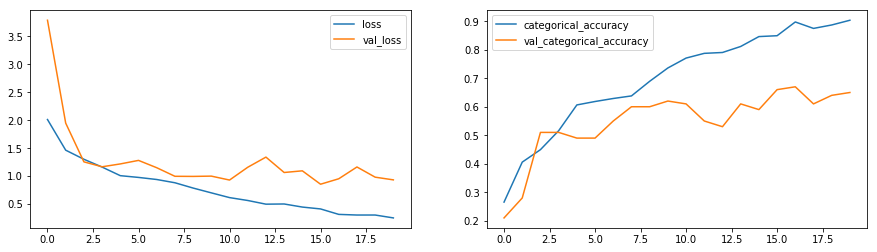

In [36]:
plot(history_3)

In [ ]:
#Perfroms better than previous models

In [ ]:
#Model 4 - Reducing number of feature maps

In [45]:
model_4 = Sequential()

model_4.add(Conv3D(8,(3,3,3),activation='relu',input_shape=(15,100,100,3)))
model_4.add(BatchNormalization())
model_4.add(Conv3D(8,(3,3,3),activation='relu'))
model_4.add(BatchNormalization())
model_4.add(MaxPooling3D(pool_size=(1, 2, 2)))
model_4.add(Dropout(0.25))

model_4.add(Conv3D(32,(3,5,5), activation='relu'))
model_4.add(BatchNormalization())
model_4.add(MaxPooling3D(pool_size=(2, 2, 2)))
model_4.add(Conv3D(64,(3,3,5), activation='relu'))
model_4.add(BatchNormalization())
model_4.add(MaxPooling3D(pool_size=(1, 1, 4 )))
model_4.add(Dropout(0.25))

model_4.add(Flatten())
model_4.add(Dense(512, activation='relu'))
model_4.add(Dropout(0.5))

model_4.add(Dense(256, activation='relu'))
model_4.add(Dropout(0.5))

model_4.add(Dense(5,kernel_initializer='normal'))

model_4.add(Activation('softmax'))

In [46]:
optimiser = optimizers.SGD(lr=0.01,momentum=0.9)
model_4.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print(model_4.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_22 (Conv3D)           (None, 13, 98, 98, 8)     656       
_________________________________________________________________
batch_normalization_24 (Batc (None, 13, 98, 98, 8)     32        
_________________________________________________________________
conv3d_23 (Conv3D)           (None, 11, 96, 96, 8)     1736      
_________________________________________________________________
batch_normalization_25 (Batc (None, 11, 96, 96, 8)     32        
_________________________________________________________________
max_pooling3d_19 (MaxPooling (None, 11, 48, 48, 8)     0         
_________________________________________________________________
dropout_21 (Dropout)         (None, 11, 48, 48, 8)     0         
_________________________________________________________________
conv3d_24 (Conv3D)           (None, 9, 44, 44, 32)     19232     
__________

In [42]:
train_generator_4 = generator(train_path, train_doc, batch_size)
val_generator_4 = generator(val_path, val_doc, batch_size)

callbacks_list = get_callback_list()

history_4=model_4.fit_generator(train_generator_4, steps_per_epoch=steps_per_epoch, epochs=20,
                                          verbose=1, callbacks=callbacks_list, validation_data=val_generator_4, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  ./Project_data/val ; batch size = 32
Source path =  ./Project_data/train ; batch size = 32
Epoch 1/20


/mnt/disks/user/anaconda3/lib/python3.6/site-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/mnt/disks/user/anaconda3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


21/21 [==============================] - 67s 3s/step - loss: 2.6147 - categorical_accuracy: 0.3071 - val_loss: 5.6169 - val_categorical_accuracy: 0.1800

Epoch 00001: saving model to model_init_2020-08-1618_53_56.183368/model-00001-2.60149-0.30769-5.61687-0.18000.h5
Epoch 2/20
21/21 [==============================] - 52s 2s/step - loss: 2.2299 - categorical_accuracy: 0.3348 - val_loss: 2.2896 - val_categorical_accuracy: 0.2300

Epoch 00002: saving model to model_init_2020-08-1618_53_56.183368/model-00002-2.23058-0.33635-2.28965-0.23000.h5
Epoch 3/20
21/21 [==============================] - 57s 3s/step - loss: 1.7412 - categorical_accuracy: 0.3491 - val_loss: 1.5912 - val_categorical_accuracy: 0.2600

Epoch 00003: saving model to model_init_2020-08-1618_53_56.183368/model-00003-1.74650-0.34691-1.59122-0.26000.h5
Epoch 4/20
21/21 [==============================] - 51s 2s/step - loss: 1.5034 - categorical_accuracy: 0.4158 - val_loss: 1.5817 - val_categorical_accuracy: 0.3200

Epoch 00004:

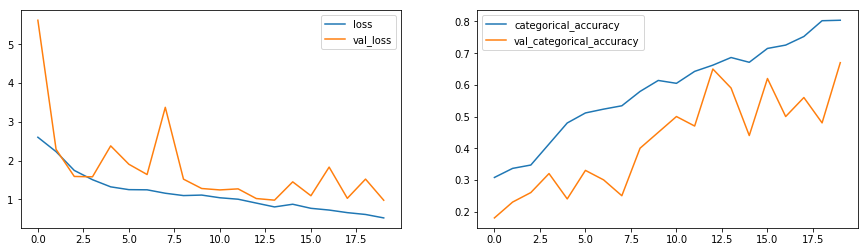

In [43]:
plot(history_4)

In [ ]:
#Better model, better accuracy at the end of the last epoch

In [ ]:
#Model with Transfer learning performs better over all